In [14]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from fourier_2d import FNO2d
from fourier import FNO1d
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

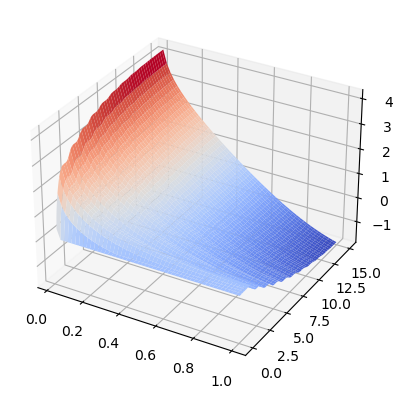

In [17]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("u.mat")["uData"]
x = x.reshape(npoints, nt, nx).astype(np.float32)
y = scipy.io.loadmat("thetaHat.mat")["tHatData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    


x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[0, :, :], cmap=cm.coolwarm)

In [18]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 12
width = 64

In [19]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [20]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [21]:
model = FNO1d(modes, width, 50, 50).cuda()
print(count_params(model))

427954


In [22]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [23]:
t = default_timer()
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)

        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)

0 0.35012286901474 0.7844609936078389 0.6051942706108093
50 0.2136103631928563 0.051841747098498876 0.05502294078469276
100 0.3913602698594332 0.030386844525734584 0.02381473742425442
150 0.23250220576301217 0.021705625827113786 0.017913484200835227
200 0.24570751888677478 0.014608777252336343 0.011889282986521721
250 0.24999234126880765 0.013311833370890883 0.01164155025035143
300 0.24956222297623754 0.009023666557752424 0.008978173043578863
350 0.24581247987225652 0.008677934223992958 0.008855707198381423
400 0.24667646503075957 0.0075335008713106315 0.007755414769053459
450 0.24819523375481367 0.0068147586658597 0.008265689201653003
500 0.2110402979888022 0.006052827421161863 0.0069789508357644085
550 0.21081826090812683 0.005914010086821186 0.006909800227731466
600 0.20052475715056062 0.005639410039616956 0.0065783183090388775
650 0.33318669721484184 0.00553968268343144 0.006628383696079254
700 0.18255152506753802 0.005374858859512541 0.006446487829089164
750 0.18296777922660112 0.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


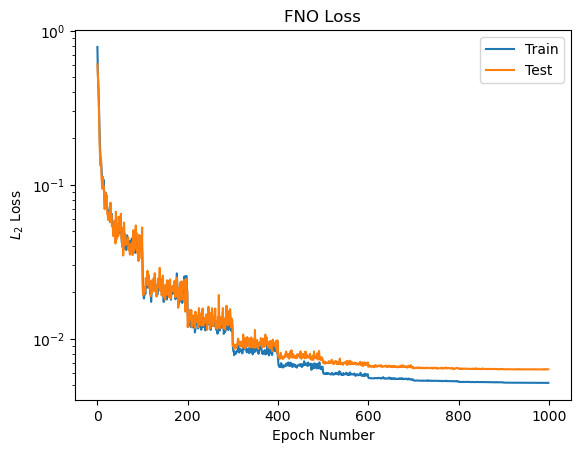

In [24]:
plt.title("FNO Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('fno.eps')

/tmp/ipykernel_2398686/3216698936.py:13: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efbbe1fa3d0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend([l1, l2], ["Neural Network Model", "Statistical Parameter Estimator"])
/tmp/ipykernel_2398686/3216698936.py:13: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7efbbe1fa6d0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend([l1, l2], ["Neural Network Model", "Statistical Parameter Estimator"])
/tmp/ipykernel_2398686/3216698936.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


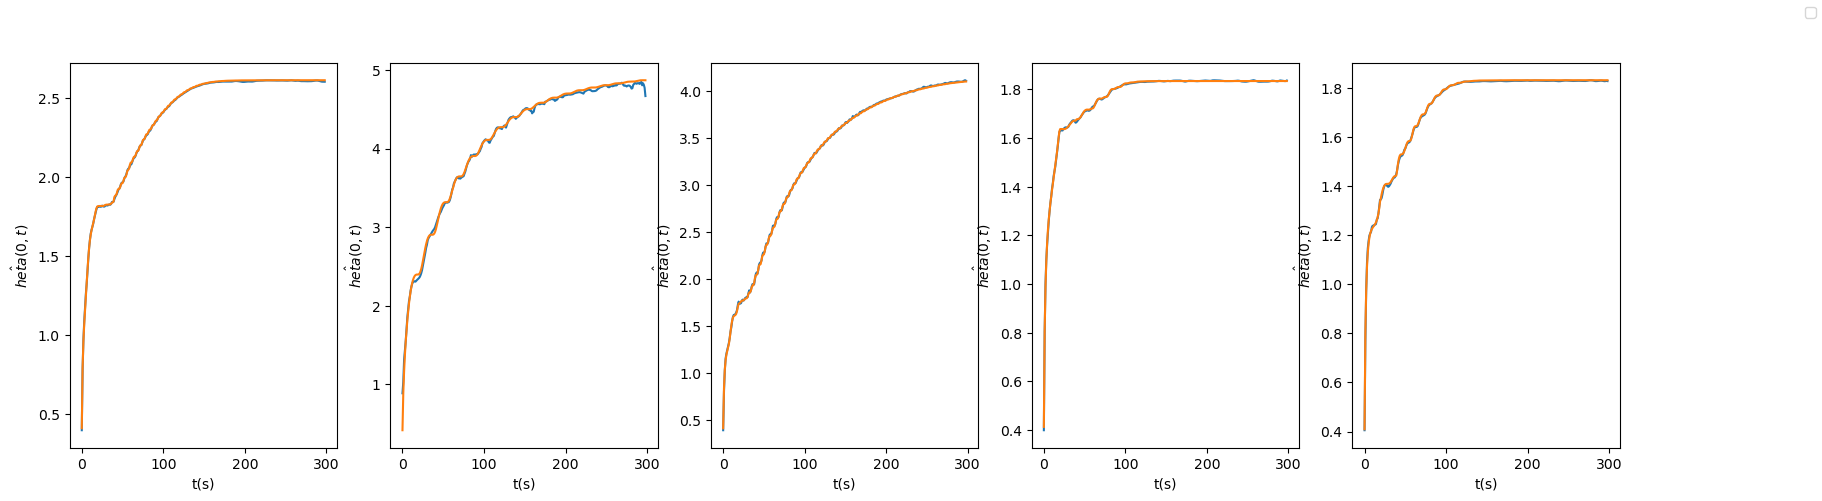

In [29]:
# Show some examples at the boundry
index = 0
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        l1 = ax[index].plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        l2 = ax[index].plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        ax[index].set_xlabel("t(s)")
        ax[index].set_ylabel("$\hat{\theta}(0, t)$")
        index+=1
fig.legend([l1, l2], ["Neural Network Model", "Statistical Parameter Estimator"])
fig.show()

Text(0.5, 0, '$\\tilde{\\hat{\\theta}}$')

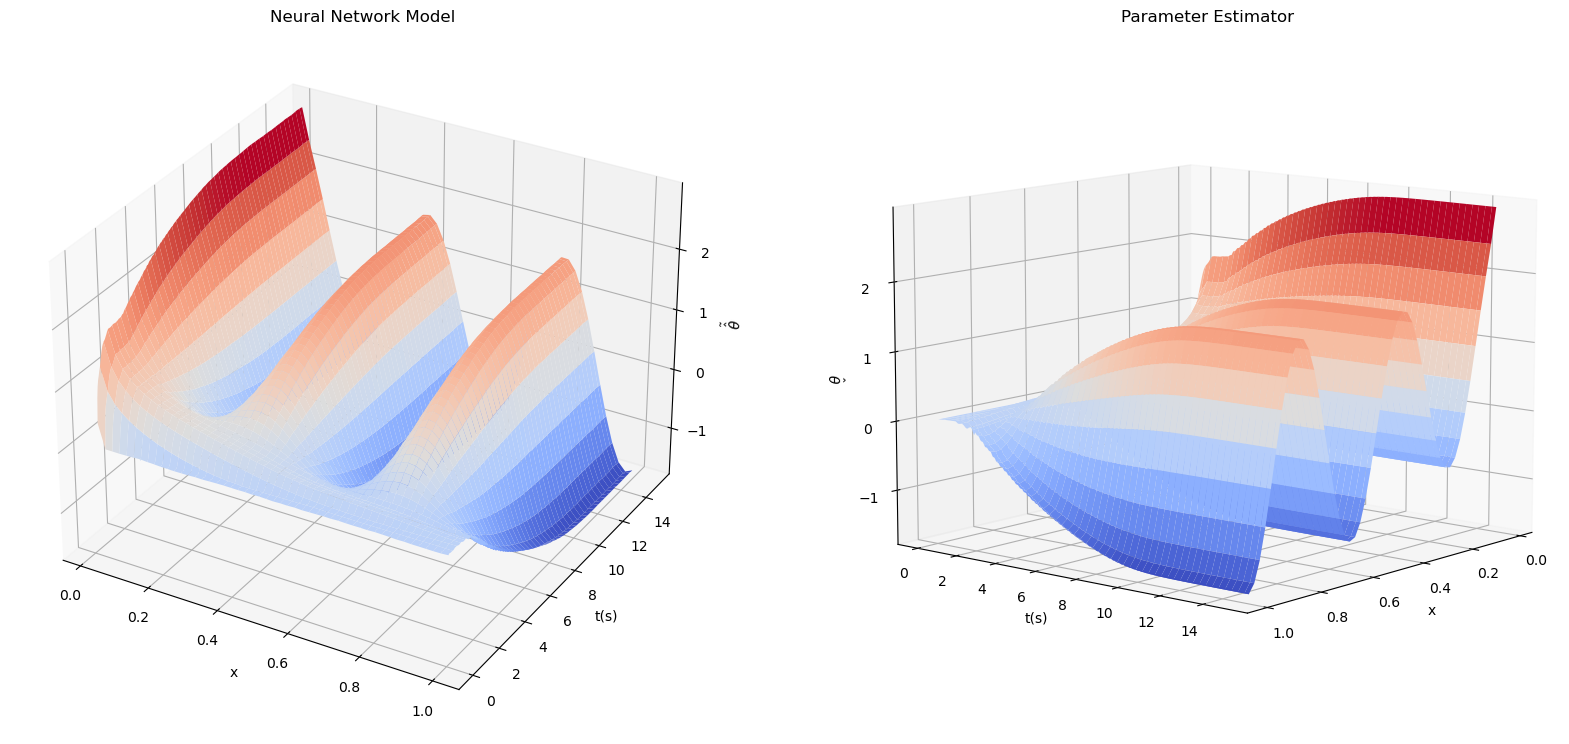

In [26]:
t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)
x1, t1 = np.meshgrid(x1, t1)

fig, ax = plt.subplots(1, 2,figsize=(20, 20), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(x1, t1, out.cpu().detach().numpy()[2, :, :], cmap=cm.coolwarm, label="Neural Network Model")
surf = ax[1].plot_surface(x1, t1, y.cpu().detach().numpy()[2, :, 0:50], cmap=cm.coolwarm, label="Statistical Parameter Estimator")
ax[0].title.set_text("Neural Network Model")
ax[1].title.set_text("Parameter Estimator")
ax[0].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_ylabel("t(s)")
ax[1].set_ylabel("t(s)")
ax[1].view_init(10, 40)
ax[1].set_zlabel(r'$\hat{\theta}$')
ax[0].set_zlabel(r'$\tilde{\hat{\theta}}$')

In [27]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)

        test_mse += loss(out, y).item()
print("TEST MSE For " + str(batch_size) + " Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.006324043869972229


In [28]:
torch.save(model.state_dict(), 'fnoModel1')